In [1]:
#!pip install keras
#!pip install numpy
#!pip install imageio
#!pip install matplotlib
#!pip install opencv-python

import threading
import sys
import cv2
import sys
import os
import csv
import itertools
import numpy as np
from PIL import Image
import imageio
import itertools as it
import tensorflow as tf
import keras
print("Keras version %s" % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

print("Tensorflow version %s" % tf.__version__)

import pprint
pp = pprint.PrettyPrinter(depth=6)

Using TensorFlow backend.


Keras version 2.0.4
Tensorflow version 1.1.0


In [2]:
# Add the standard include path for FoosMetrics
sys.path.insert(0, './../../Code')

import importlib
import process
importlib.reload(process)

<module 'process' from './../../Code\\process.py'>

In [3]:
# Load the data and frames, and add the normalizer
training = process.Processor("data_loader_training.json")
validation = process.Processor("data_loader_validation.json")
output_names = ["g1","d1","o1","f1","f2","o2","d2","g2","-2"]

Creating transform: random_video_loader
Adding folder '.\..\..\Data\Processed\BallTracking\'
'.\..\..\Data\Processed\BallTracking\balltracking_0.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_1.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_10.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_11.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_12.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_13.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_14.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_15.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_16.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_17.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\balltracking_18.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\bal

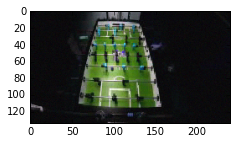

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])


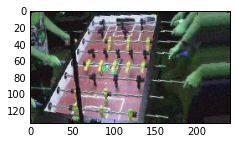

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


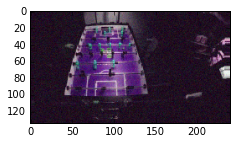

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])


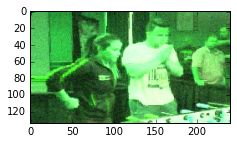

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])


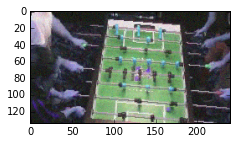

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


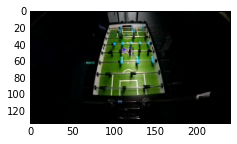

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


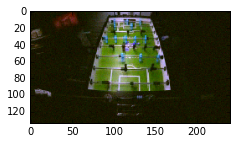

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])


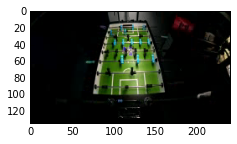

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


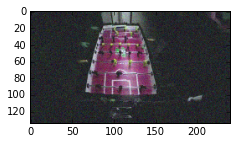

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])


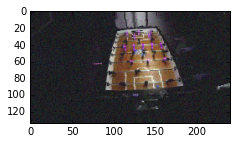

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


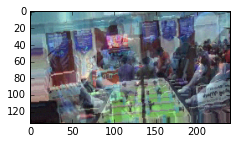

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])


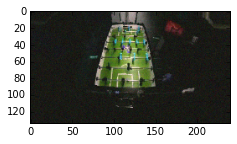

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


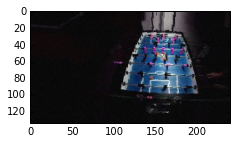

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


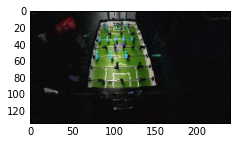

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


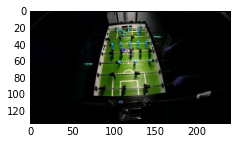

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


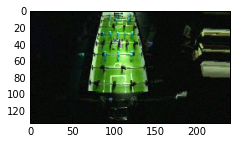

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


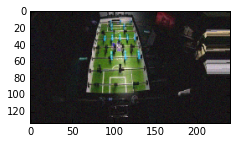

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]])


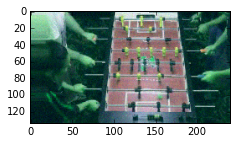

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


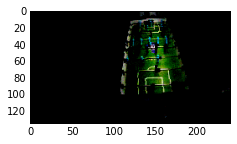

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])


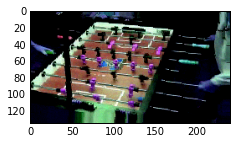

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


In [4]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# View the first few frames
for k in range(20):
    data = training.get_next_frame()
    frame = data["frame"]
    fig, ax = plt.subplots(figsize=(18, 2))
    plt.imshow(frame)
    plt.show()
    pp.pprint( np.transpose( np.array(data["values"] ) ))

In [5]:
# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
class threadsafe_iter(object):
  """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
  def __init__(self, it):
      self.it = it
      self.lock = threading.Lock()

  def __iter__(self):
      return self

  def __next__(self):
      with self.lock:
          return self.it.__next__()

# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
def threadsafe_generator(f):
  """
    A decorator that takes a generator function and makes it thread-safe.
    """
  def g(*a, **kw):
      return threadsafe_iter(f(*a, **kw))
  return g


# Define our training and validation iterators
@threadsafe_generator
def TrainGen(training):
    while True:
        data = training.get_next_frame()
        if data is not None:
            frame = data["frame"]
            output = np.array(data["values"])

            while frame is not None:
                yield (frame, output)
                data = training.get_next_frame()
                if data is not None:
                    frame = data["frame"]
                    output = np.array(data["values"])
                else:
                    frame = None
                
             
# Generators for training the position
@threadsafe_generator
def TrainBatchGen(batch_size, training):
    gen = TrainGen(training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 9), dtype=np.float32)
        for i in range(batch_size):
            (frame, output) = next(gen)
            batch_frames[i,:,:,:] = frame
            batch_outputs[i,:] = output[:,0]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

                
             
# Generators for training the position
@threadsafe_generator
def ValidationBatchGen(batch_size, validation):
    gen = TrainGen(validation)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 9), dtype=np.float32)
        for i in range(batch_size):
            (frame, output) = next(gen)
            batch_frames[i,:,:,:] = frame
            batch_outputs[i,:] = output[:,0]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")
        
    
    
        
    


In [6]:
# Utilities for plotting the result and training
def plot_validate(generator, model, count, name, output_names):   
    outputs_predicted = None
    outputs_true = None
    
    while outputs_predicted is None or outputs_predicted.shape[0] < count:
        
        (new_frames, new_outputs_true) = next(generator)
        if outputs_true is None:
            outputs_true = new_outputs_true
        else:
            outputs_true = np.concatenate( (outputs_true, new_outputs_true), axis=0 )
        
        
        new_outputs_predicted = model.predict(new_frames, batch_size=new_frames.shape[0], verbose=0)
        if outputs_predicted is None:
            outputs_predicted = new_outputs_predicted
        else:
            outputs_predicted = np.concatenate( (outputs_predicted, new_outputs_predicted), axis=0 )
    
    
    f, axes = plt.subplots(outputs_true.shape[1], figsize=(12, 12), sharex=True, sharey=True)
    
    for i in range(outputs_true.shape[1]):
        true, predicted = zip(*sorted(zip(outputs_true[0:count,i], outputs_predicted[0:count,i])))
        axes[i].plot(range(count),true, label="True position" )
        axes[i].plot(range(count),predicted, label="Predicted position" )
        axes[i].grid(False)
        axes[i].set_ylabel(output_names[i])
        if i == 0:
            axes[i].legend()
            axes[i].set_title(name)
            
    
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    
    
    plt.show()

    
    



In [ ]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model



image_height       = 134
image_width        = 240
image_channels     = 3

# Model options
batch_size = 10
lstm_output_size = 300
cnn_kernel_count = 40

# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_height, image_width, image_channels))

# Used to give fixed names to the layers for transferring the model
conv_num = 0 
pool_num = 0
dense_num = 0

# Build a functional model design
inputs = Input(shape=(image_height, image_width, image_channels,),
              name="Input")
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "conv2d_%i"%conv_num)(inputs)
conv_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "conv2d_%i"%conv_num)(x)
conv_num+=1

# Split into a horizontal detail and vertical detailed CNN paths
x = MaxPooling2D( pool_size=(1, 2),
                  name = "max_pooling2d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1

x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1


#x = Flatten()(x)
#x = Reshape((number_of_frames,6*6*cnn_kernel_count))(x)
x = Flatten()(x)


x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(64, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
predictions = Dense(9, activation='softmax',name="dense_%i"%dense_num)(x)
dense_num+=1

model = Model(inputs=inputs, outputs=predictions)


# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


model.summary()

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = '.\\Goalie3Frames\\weights_%i.hdf'
MODELS_FNAME = '.\\Goalie3Frames\\models_%i.h5'

'Input shape without batches:'
(134, 240, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 134, 240, 3)       0         
_________________________________________________________________
conv2d_0 (Conv2D)            (None, 134, 240, 40)      1120      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 134, 240, 40)      14440     
_________________________________________________________________
max_pooling2d_0 (MaxPooling2 (None, 134, 120, 40)      0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 134, 120, 40)      14440     
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 134, 120, 40)      14440     
_________________________________________________________________
max_pooling3d_1 (MaxPooling2 (N

Batch size 30: 1355 training batches, 338 validation batches
Epoch 1/1
1356/1355 [==============================] - 631s - loss: 2.1700 - categorical_accuracy: 0.1413 - val_loss: 2.0778 - val_categorical_accuracy: 0.2272


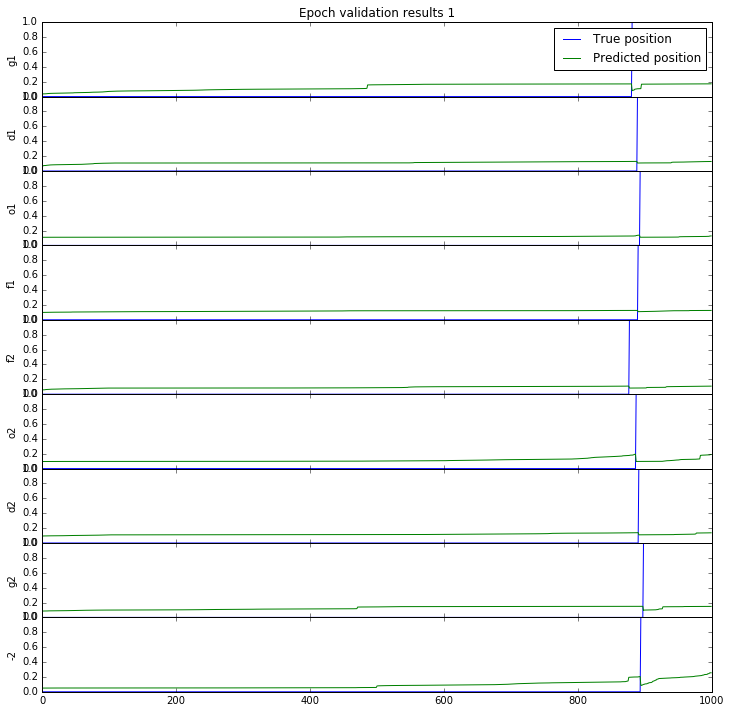

Wrote model to .\Models\weights_1.hdf
Epoch 2/2
1356/1355 [==============================] - 629s - loss: 2.0825 - categorical_accuracy: 0.1935 - val_loss: 1.9335 - val_categorical_accuracy: 0.2512
Wrote model to .\Models\weights_2.hdf
Epoch 3/3
1356/1355 [==============================] - 634s - loss: 2.0146 - categorical_accuracy: 0.2200 - val_loss: 1.8691 - val_categorical_accuracy: 0.2791
Wrote model to .\Models\weights_3.hdf
Epoch 4/4
1356/1355 [==============================] - 636s - loss: 1.9635 - categorical_accuracy: 0.2417 - val_loss: 1.8431 - val_categorical_accuracy: 0.3812
Wrote model to .\Models\weights_4.hdf
Epoch 5/5
1356/1355 [==============================] - 633s - loss: 1.9335 - categorical_accuracy: 0.2587 - val_loss: 1.7812 - val_categorical_accuracy: 0.4129
Wrote model to .\Models\weights_5.hdf
Epoch 6/6
1356/1355 [==============================] - 635s - loss: 1.9082 - categorical_accuracy: 0.2644 - val_loss: 1.7338 - val_categorical_accuracy: 0.4385
Wrote mode

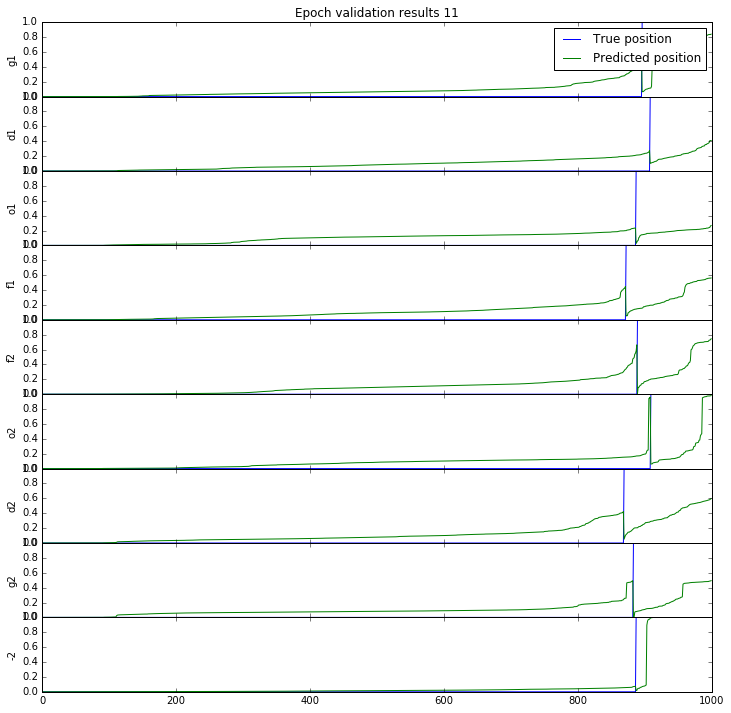

Wrote model to .\Models\weights_11.hdf
Epoch 12/12
1356/1355 [==============================] - 631s - loss: 1.6971 - categorical_accuracy: 0.3629 - val_loss: 1.1217 - val_categorical_accuracy: 0.6686
Wrote model to .\Models\weights_12.hdf
Epoch 13/13
1356/1355 [==============================] - 632s - loss: 1.6661 - categorical_accuracy: 0.3746 - val_loss: 1.0787 - val_categorical_accuracy: 0.6745
Wrote model to .\Models\weights_13.hdf
Epoch 14/14
1356/1355 [==============================] - 628s - loss: 1.6460 - categorical_accuracy: 0.3867 - val_loss: 0.9880 - val_categorical_accuracy: 0.7177
Wrote model to .\Models\weights_14.hdf
Epoch 15/15
1356/1355 [==============================] - 625s - loss: 1.6047 - categorical_accuracy: 0.4023 - val_loss: 0.9439 - val_categorical_accuracy: 0.7371
Wrote model to .\Models\weights_15.hdf
Epoch 16/16
1356/1355 [==============================] - 633s - loss: 1.5793 - categorical_accuracy: 0.4159 - val_loss: 0.9235 - val_categorical_accuracy: 0.

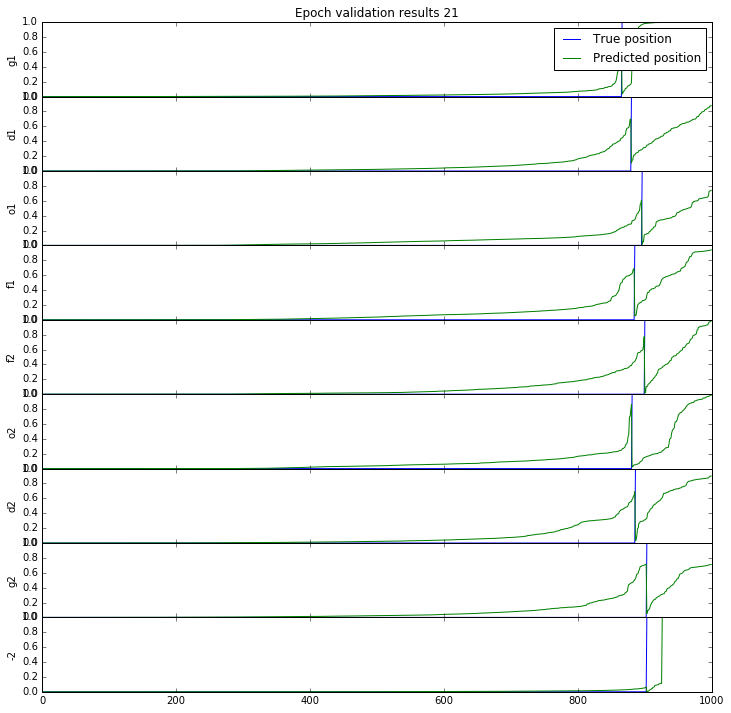

Wrote model to .\Models\weights_21.hdf
Epoch 22/22
1356/1355 [==============================] - 631s - loss: 1.4253 - categorical_accuracy: 0.4771 - val_loss: 0.6769 - val_categorical_accuracy: 0.7953
Wrote model to .\Models\weights_22.hdf
Epoch 23/23
1356/1355 [==============================] - 638s - loss: 1.4181 - categorical_accuracy: 0.4821 - val_loss: 0.6697 - val_categorical_accuracy: 0.7926
Wrote model to .\Models\weights_23.hdf
Epoch 24/24
1356/1355 [==============================] - 640s - loss: 1.3858 - categorical_accuracy: 0.4932 - val_loss: 0.6209 - val_categorical_accuracy: 0.8069
Wrote model to .\Models\weights_24.hdf
Epoch 25/25
1356/1355 [==============================] - 629s - loss: 1.3648 - categorical_accuracy: 0.5014 - val_loss: 0.6135 - val_categorical_accuracy: 0.8165
Wrote model to .\Models\weights_25.hdf
Epoch 26/26
1356/1355 [==============================] - 629s - loss: 1.3484 - categorical_accuracy: 0.5113 - val_loss: 0.6078 - val_categorical_accuracy: 0.

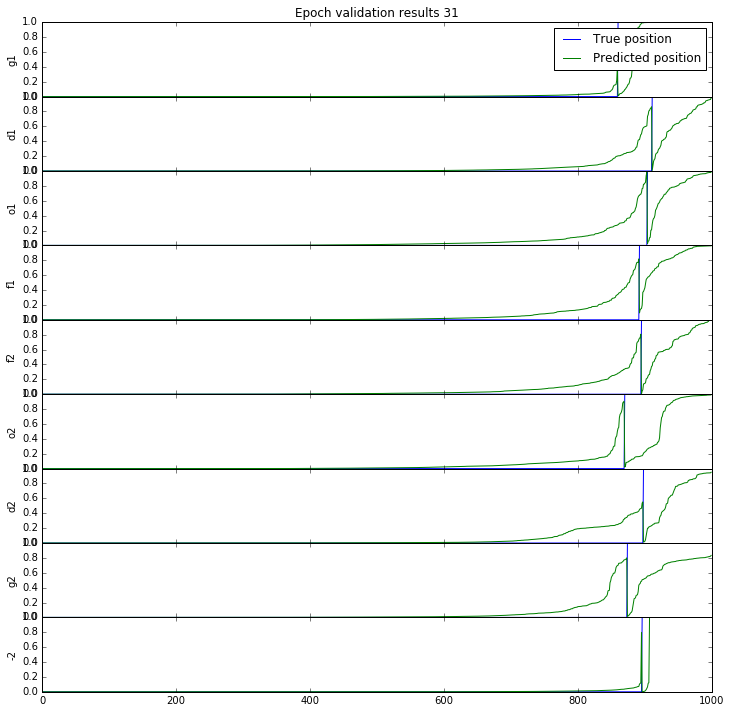

Wrote model to .\Models\weights_31.hdf
Epoch 32/32
1356/1355 [==============================] - 630s - loss: 1.2331 - categorical_accuracy: 0.5575 - val_loss: 0.5119 - val_categorical_accuracy: 0.8348
Wrote model to .\Models\weights_32.hdf
Epoch 33/33
1356/1355 [==============================] - 634s - loss: 1.2267 - categorical_accuracy: 0.5626 - val_loss: 0.4834 - val_categorical_accuracy: 0.8362
Wrote model to .\Models\weights_33.hdf
Epoch 34/34
1356/1355 [==============================] - 634s - loss: 1.1983 - categorical_accuracy: 0.5719 - val_loss: 0.4836 - val_categorical_accuracy: 0.8410
Wrote model to .\Models\weights_34.hdf
Epoch 35/35
1356/1355 [==============================] - 635s - loss: 1.1874 - categorical_accuracy: 0.5759 - val_loss: 0.4586 - val_categorical_accuracy: 0.8387
Wrote model to .\Models\weights_35.hdf
Epoch 36/36
1356/1355 [==============================] - 634s - loss: 1.1723 - categorical_accuracy: 0.5820 - val_loss: 0.4390 - val_categorical_accuracy: 0.

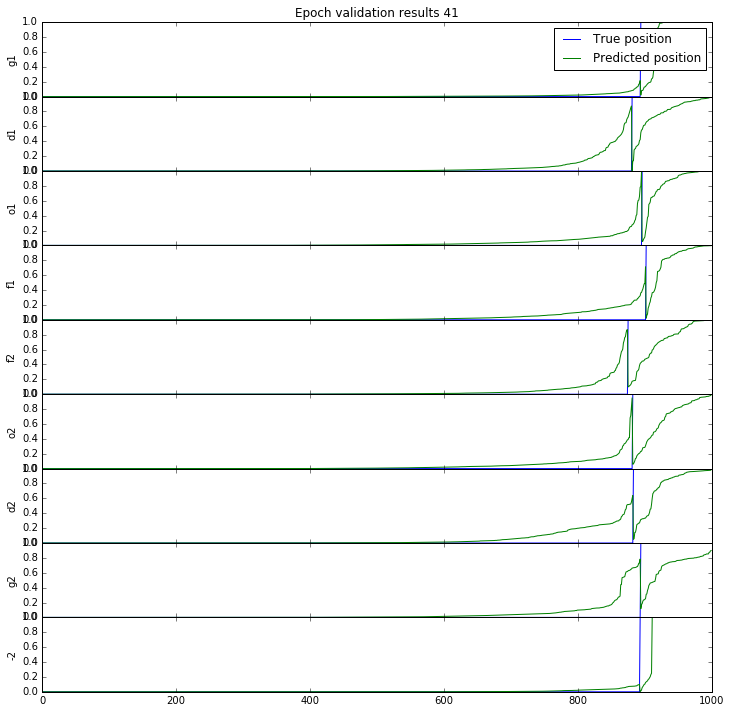

Wrote model to .\Models\weights_41.hdf
Epoch 42/42
1356/1355 [==============================] - 636s - loss: 1.0945 - categorical_accuracy: 0.6146 - val_loss: 0.4047 - val_categorical_accuracy: 0.8671
Wrote model to .\Models\weights_42.hdf
Epoch 43/43
1356/1355 [==============================] - 633s - loss: 1.0813 - categorical_accuracy: 0.6211 - val_loss: 0.3808 - val_categorical_accuracy: 0.8680
Wrote model to .\Models\weights_43.hdf
Epoch 44/44
1356/1355 [==============================] - 631s - loss: 1.0586 - categorical_accuracy: 0.6295 - val_loss: 0.3509 - val_categorical_accuracy: 0.8795
Wrote model to .\Models\weights_44.hdf
Epoch 45/45
1356/1355 [==============================] - 629s - loss: 1.0366 - categorical_accuracy: 0.6364 - val_loss: 0.3444 - val_categorical_accuracy: 0.8826
Wrote model to .\Models\weights_45.hdf
Epoch 46/46
1356/1355 [==============================] - 633s - loss: 1.0334 - categorical_accuracy: 0.6395 - val_loss: 0.3477 - val_categorical_accuracy: 0.

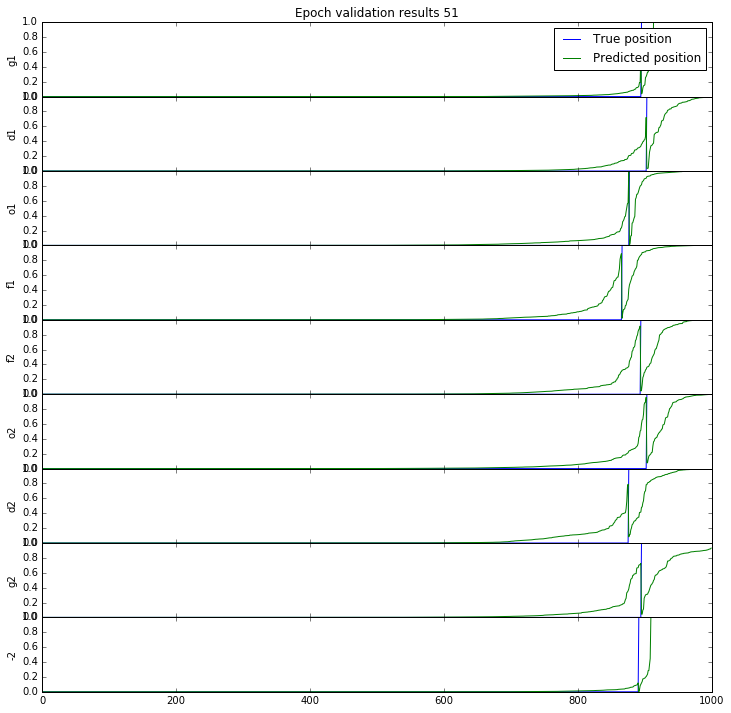

Wrote model to .\Models\weights_51.hdf
Epoch 52/52
1356/1355 [==============================] - 629s - loss: 0.9616 - categorical_accuracy: 0.6672 - val_loss: 0.2814 - val_categorical_accuracy: 0.9075
Wrote model to .\Models\weights_52.hdf
Epoch 53/53
1356/1355 [==============================] - 635s - loss: 0.9580 - categorical_accuracy: 0.6692 - val_loss: 0.2797 - val_categorical_accuracy: 0.9116
Wrote model to .\Models\weights_53.hdf
Epoch 54/54
1356/1355 [==============================] - 634s - loss: 0.9476 - categorical_accuracy: 0.6729 - val_loss: 0.2797 - val_categorical_accuracy: 0.9059
Wrote model to .\Models\weights_54.hdf
Epoch 55/55
1356/1355 [==============================] - 632s - loss: 0.9389 - categorical_accuracy: 0.6766 - val_loss: 0.2803 - val_categorical_accuracy: 0.9049
Wrote model to .\Models\weights_55.hdf
Epoch 56/56
1356/1355 [==============================] - 633s - loss: 0.9459 - categorical_accuracy: 0.6749 - val_loss: 0.2642 - val_categorical_accuracy: 0.

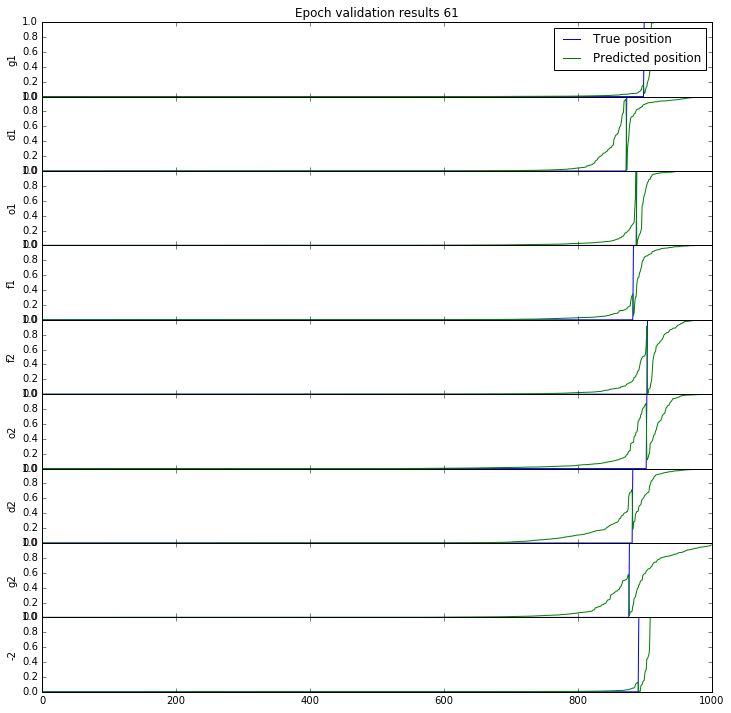

Wrote model to .\Models\weights_61.hdf
Epoch 62/62
1356/1355 [==============================] - 633s - loss: 0.8758 - categorical_accuracy: 0.7019 - val_loss: 0.2444 - val_categorical_accuracy: 0.9203
Wrote model to .\Models\weights_62.hdf
Epoch 63/63
1356/1355 [==============================] - 632s - loss: 0.8786 - categorical_accuracy: 0.6995 - val_loss: 0.2458 - val_categorical_accuracy: 0.9240
Wrote model to .\Models\weights_63.hdf
Epoch 64/64
1356/1355 [==============================] - 632s - loss: 0.8557 - categorical_accuracy: 0.7073 - val_loss: 0.2214 - val_categorical_accuracy: 0.9272
Wrote model to .\Models\weights_64.hdf
Epoch 65/65
1356/1355 [==============================] - 632s - loss: 0.8689 - categorical_accuracy: 0.7052 - val_loss: 0.2535 - val_categorical_accuracy: 0.9241
Wrote model to .\Models\weights_65.hdf
Epoch 66/66
1356/1355 [==============================] - 628s - loss: 0.8495 - categorical_accuracy: 0.7125 - val_loss: 0.2383 - val_categorical_accuracy: 0.

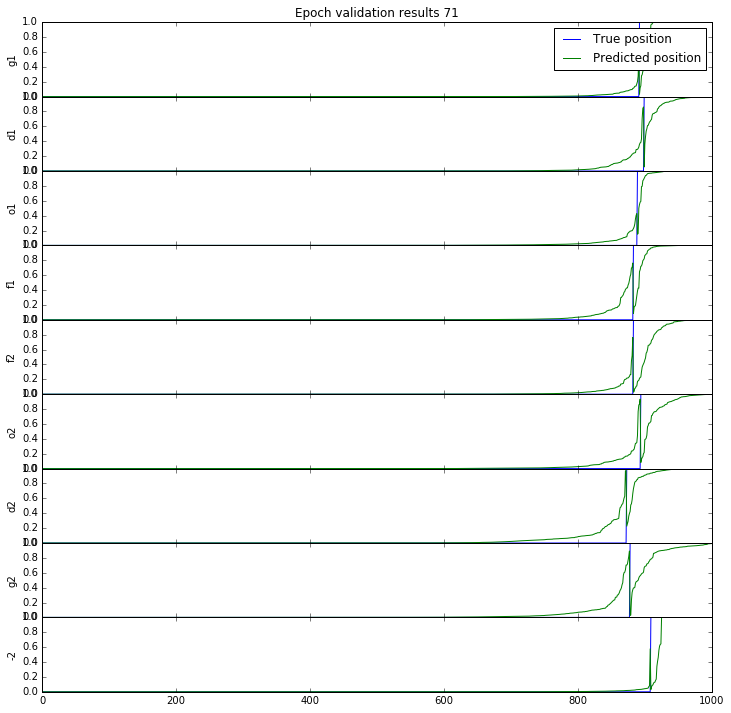

Wrote model to .\Models\weights_71.hdf
Epoch 72/72
1356/1355 [==============================] - 629s - loss: 0.8144 - categorical_accuracy: 0.7248 - val_loss: 0.2015 - val_categorical_accuracy: 0.9346
Wrote model to .\Models\weights_72.hdf
Epoch 73/73
1356/1355 [==============================] - 631s - loss: 0.8096 - categorical_accuracy: 0.7279 - val_loss: 0.2000 - val_categorical_accuracy: 0.9345
Wrote model to .\Models\weights_73.hdf
Epoch 74/74
1356/1355 [==============================] - 632s - loss: 0.7928 - categorical_accuracy: 0.7312 - val_loss: 0.2059 - val_categorical_accuracy: 0.9393
Wrote model to .\Models\weights_74.hdf
Epoch 75/75
1356/1355 [==============================] - 631s - loss: 0.8010 - categorical_accuracy: 0.7308 - val_loss: 0.1969 - val_categorical_accuracy: 0.9388
Wrote model to .\Models\weights_75.hdf
Epoch 76/76
1356/1355 [==============================] - 635s - loss: 0.7923 - categorical_accuracy: 0.7346 - val_loss: 0.1963 - val_categorical_accuracy: 0.

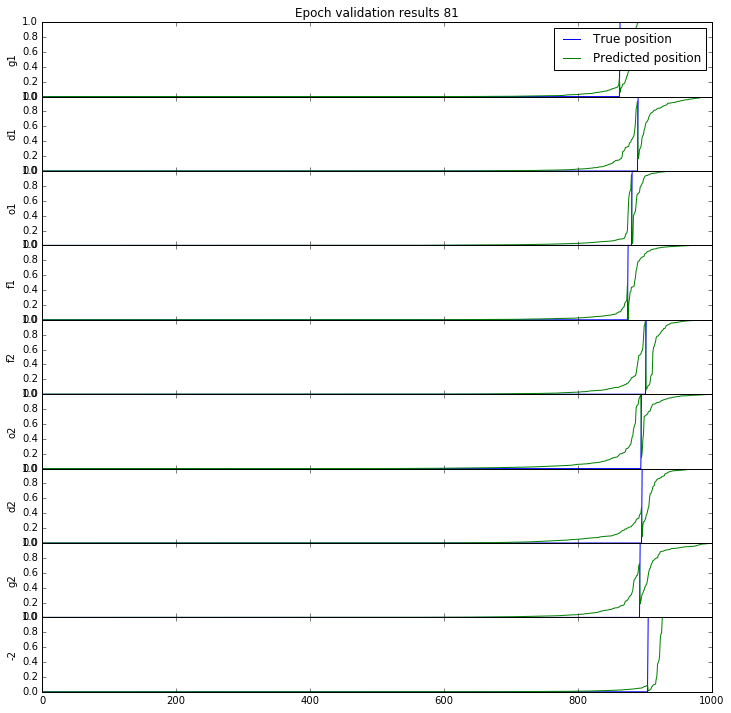

Wrote model to .\Models\weights_81.hdf
Epoch 82/82
1356/1355 [==============================] - 629s - loss: 0.7544 - categorical_accuracy: 0.7454 - val_loss: 0.1767 - val_categorical_accuracy: 0.9425
Wrote model to .\Models\weights_82.hdf
Epoch 83/83
1356/1355 [==============================] - 629s - loss: 0.7491 - categorical_accuracy: 0.7490 - val_loss: 0.1713 - val_categorical_accuracy: 0.9464
Wrote model to .\Models\weights_83.hdf
Epoch 84/84
1356/1355 [==============================] - 629s - loss: 0.7499 - categorical_accuracy: 0.7493 - val_loss: 0.1770 - val_categorical_accuracy: 0.9479
Wrote model to .\Models\weights_84.hdf
Epoch 85/85
1356/1355 [==============================] - 627s - loss: 0.7437 - categorical_accuracy: 0.7515 - val_loss: 0.2289 - val_categorical_accuracy: 0.9269
Wrote model to .\Models\weights_85.hdf
Epoch 86/86
1356/1355 [==============================] - 631s - loss: 0.7435 - categorical_accuracy: 0.7516 - val_loss: 0.1915 - val_categorical_accuracy: 0.

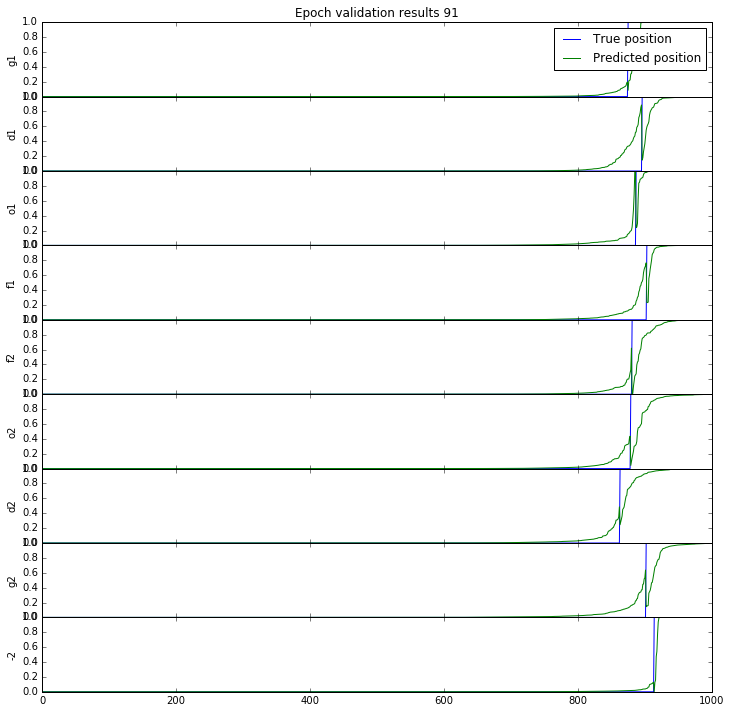

Wrote model to .\Models\weights_91.hdf
Epoch 92/92
1356/1355 [==============================] - 630s - loss: 0.7054 - categorical_accuracy: 0.7662 - val_loss: 0.1705 - val_categorical_accuracy: 0.9459
Wrote model to .\Models\weights_92.hdf
Epoch 93/93
1356/1355 [==============================] - 629s - loss: 0.7157 - categorical_accuracy: 0.7640 - val_loss: 0.1653 - val_categorical_accuracy: 0.9431
Wrote model to .\Models\weights_93.hdf
Epoch 94/94
1356/1355 [==============================] - 632s - loss: 0.7117 - categorical_accuracy: 0.7657 - val_loss: 0.1514 - val_categorical_accuracy: 0.9518
Wrote model to .\Models\weights_94.hdf
Epoch 95/95
1356/1355 [==============================] - 628s - loss: 0.7003 - categorical_accuracy: 0.7696 - val_loss: 0.1563 - val_categorical_accuracy: 0.9530
Wrote model to .\Models\weights_95.hdf
Epoch 96/96
1356/1355 [==============================] - 632s - loss: 0.6887 - categorical_accuracy: 0.7725 - val_loss: 0.1639 - val_categorical_accuracy: 0.

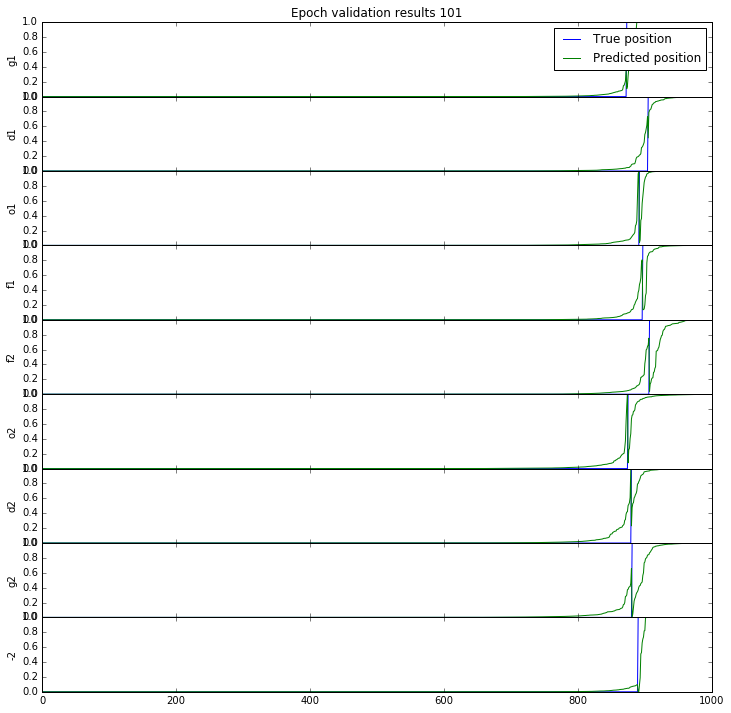

Wrote model to .\Models\weights_101.hdf
Epoch 102/102
1356/1355 [==============================] - 639s - loss: 0.6725 - categorical_accuracy: 0.7784 - val_loss: 0.1792 - val_categorical_accuracy: 0.9431
Wrote model to .\Models\weights_102.hdf
Epoch 103/103
1356/1355 [==============================] - 629s - loss: 0.6733 - categorical_accuracy: 0.7794 - val_loss: 0.1394 - val_categorical_accuracy: 0.9555
Wrote model to .\Models\weights_103.hdf
Epoch 104/104
1356/1355 [==============================] - 634s - loss: 0.6628 - categorical_accuracy: 0.7828 - val_loss: 0.1494 - val_categorical_accuracy: 0.9493
Wrote model to .\Models\weights_104.hdf
Epoch 105/105
1356/1355 [==============================] - 641s - loss: 0.6519 - categorical_accuracy: 0.7847 - val_loss: 0.1416 - val_categorical_accuracy: 0.9569
Wrote model to .\Models\weights_105.hdf
Epoch 106/106
1356/1355 [==============================] - 635s - loss: 0.6580 - categorical_accuracy: 0.7825 - val_loss: 0.1551 - val_categoric

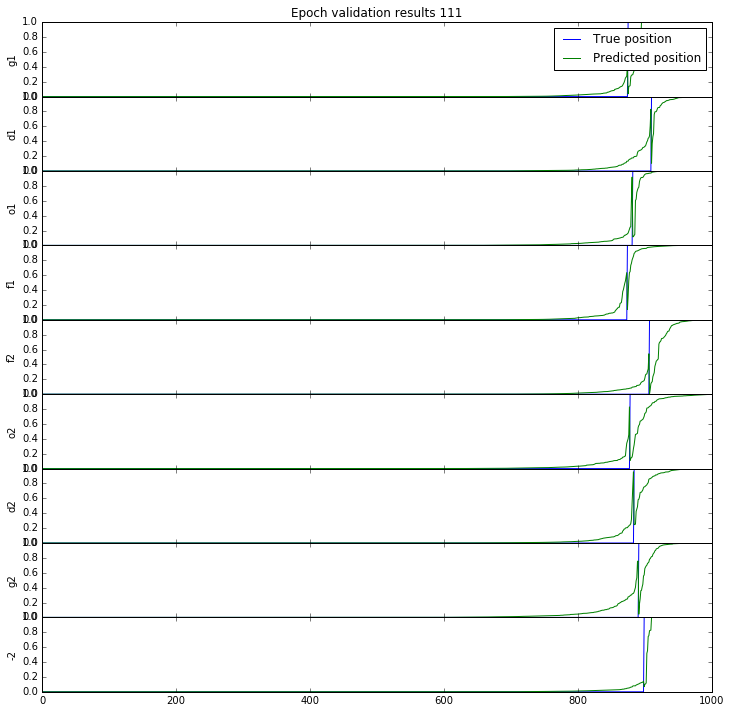

Wrote model to .\Models\weights_111.hdf
Epoch 112/112
1356/1355 [==============================] - 632s - loss: 0.6425 - categorical_accuracy: 0.7912 - val_loss: 0.1723 - val_categorical_accuracy: 0.9565
Wrote model to .\Models\weights_112.hdf
Epoch 113/113
1356/1355 [==============================] - 636s - loss: 0.6281 - categorical_accuracy: 0.7969 - val_loss: 0.1510 - val_categorical_accuracy: 0.9588
Wrote model to .\Models\weights_113.hdf
Epoch 114/114
1356/1355 [==============================] - 635s - loss: 0.6428 - categorical_accuracy: 0.7887 - val_loss: 0.1316 - val_categorical_accuracy: 0.9579
Wrote model to .\Models\weights_114.hdf
Epoch 115/115
1356/1355 [==============================] - 630s - loss: 0.6319 - categorical_accuracy: 0.7946 - val_loss: 0.1193 - val_categorical_accuracy: 0.9654
Wrote model to .\Models\weights_115.hdf
Epoch 116/116
1356/1355 [==============================] - 632s - loss: 0.6274 - categorical_accuracy: 0.7930 - val_loss: 0.1314 - val_categoric

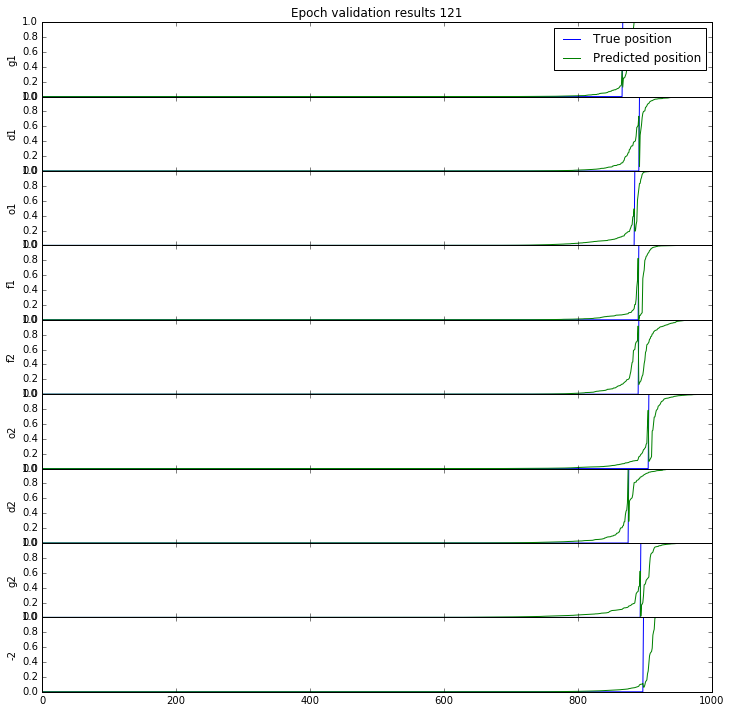

Wrote model to .\Models\weights_121.hdf
Epoch 122/122
1356/1355 [==============================] - 630s - loss: 0.6015 - categorical_accuracy: 0.8032 - val_loss: 0.1145 - val_categorical_accuracy: 0.9654
Wrote model to .\Models\weights_122.hdf
Epoch 123/123
1356/1355 [==============================] - 630s - loss: 0.6098 - categorical_accuracy: 0.8020 - val_loss: 0.1028 - val_categorical_accuracy: 0.9655
Wrote model to .\Models\weights_123.hdf
Epoch 124/124
1356/1355 [==============================] - 629s - loss: 0.6095 - categorical_accuracy: 0.8027 - val_loss: 0.1365 - val_categorical_accuracy: 0.9589
Wrote model to .\Models\weights_124.hdf
Epoch 125/125
1356/1355 [==============================] - 631s - loss: 0.6058 - categorical_accuracy: 0.8027 - val_loss: 0.1185 - val_categorical_accuracy: 0.9588
Wrote model to .\Models\weights_125.hdf
Epoch 126/126
1356/1355 [==============================] - 629s - loss: 0.6088 - categorical_accuracy: 0.8024 - val_loss: 0.1138 - val_categoric

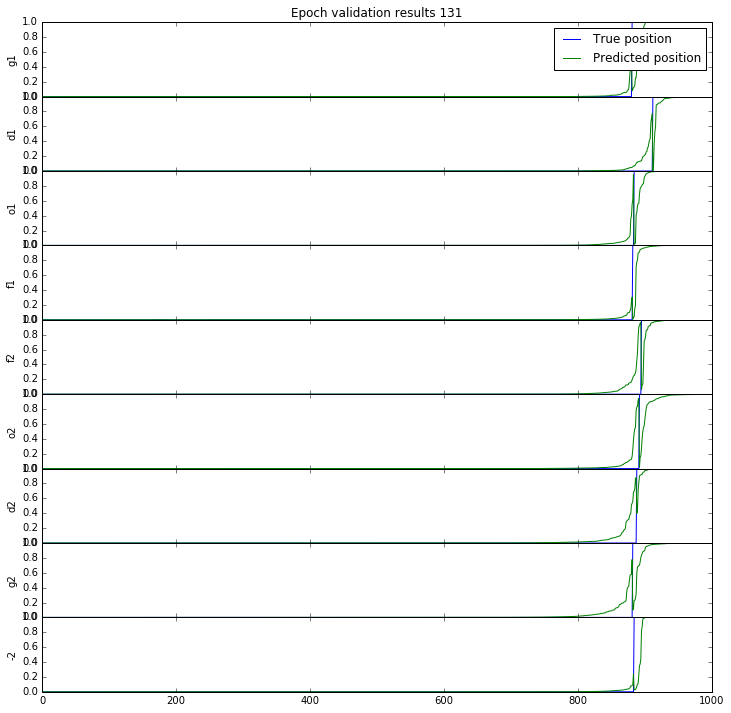

Wrote model to .\Models\weights_131.hdf
Epoch 132/132
1356/1355 [==============================] - 630s - loss: 0.5907 - categorical_accuracy: 0.8112 - val_loss: 0.1156 - val_categorical_accuracy: 0.9632
Wrote model to .\Models\weights_132.hdf
Epoch 133/133
1356/1355 [==============================] - 637s - loss: 0.5825 - categorical_accuracy: 0.8097 - val_loss: 0.1227 - val_categorical_accuracy: 0.9612
Wrote model to .\Models\weights_133.hdf
Epoch 134/134
1356/1355 [==============================] - 634s - loss: 0.5783 - categorical_accuracy: 0.8088 - val_loss: 0.1091 - val_categorical_accuracy: 0.9650
Wrote model to .\Models\weights_134.hdf
Epoch 135/135
1356/1355 [==============================] - 634s - loss: 0.5862 - categorical_accuracy: 0.8105 - val_loss: 0.1028 - val_categorical_accuracy: 0.9661
Wrote model to .\Models\weights_135.hdf
Epoch 136/136
1356/1355 [==============================] - 633s - loss: 0.5788 - categorical_accuracy: 0.8127 - val_loss: 0.1110 - val_categoric

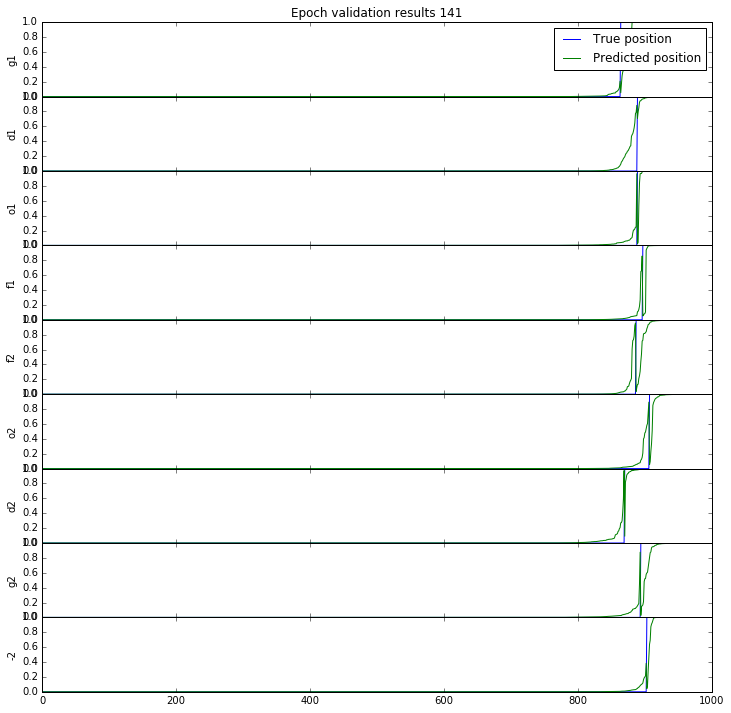

Wrote model to .\Models\weights_141.hdf
Epoch 142/142
1356/1355 [==============================] - 633s - loss: 0.5763 - categorical_accuracy: 0.8157 - val_loss: 0.1199 - val_categorical_accuracy: 0.9601
Wrote model to .\Models\weights_142.hdf
Epoch 143/143
1356/1355 [==============================] - 634s - loss: 0.5641 - categorical_accuracy: 0.8192 - val_loss: 0.0960 - val_categorical_accuracy: 0.9724
Wrote model to .\Models\weights_143.hdf
Epoch 144/144
1356/1355 [==============================] - 632s - loss: 0.5610 - categorical_accuracy: 0.8199 - val_loss: 0.1258 - val_categorical_accuracy: 0.9684
Wrote model to .\Models\weights_144.hdf
Epoch 145/145
1356/1355 [==============================] - 635s - loss: 0.5653 - categorical_accuracy: 0.8189 - val_loss: 0.1132 - val_categorical_accuracy: 0.9654
Wrote model to .\Models\weights_145.hdf
Epoch 146/146
1356/1355 [==============================] - 631s - loss: 0.5551 - categorical_accuracy: 0.8216 - val_loss: 0.1019 - val_categoric

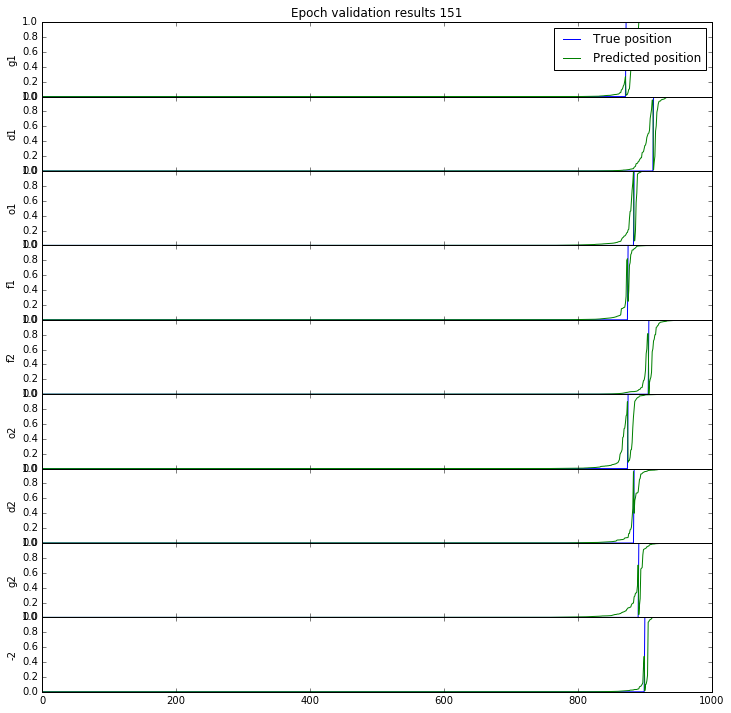

Wrote model to .\Models\weights_151.hdf
Epoch 152/152
1356/1355 [==============================] - 632s - loss: 0.5479 - categorical_accuracy: 0.8241 - val_loss: 0.1172 - val_categorical_accuracy: 0.9639
Wrote model to .\Models\weights_152.hdf
Epoch 153/153
1356/1355 [==============================] - 631s - loss: 0.5379 - categorical_accuracy: 0.8264 - val_loss: 0.1136 - val_categorical_accuracy: 0.9683
Wrote model to .\Models\weights_153.hdf
Epoch 154/154
1356/1355 [==============================] - 630s - loss: 0.5480 - categorical_accuracy: 0.8252 - val_loss: 0.0980 - val_categorical_accuracy: 0.9719
Wrote model to .\Models\weights_154.hdf
Epoch 155/155
1356/1355 [==============================] - 631s - loss: 0.5412 - categorical_accuracy: 0.8271 - val_loss: 0.0877 - val_categorical_accuracy: 0.9715
Wrote model to .\Models\weights_155.hdf
Epoch 156/156
 643/1355 [=============>................] - ETA: 309s - loss: 0.5389 - categorical_accuracy: 0.8263

In [ ]:
# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Was ran on the above simple model, not pre-trained Inceptionv3 run.
epoch = 0
#batches_validation_per_epoch = 50
#batches_training_per_epoch = 400
batch_size = 30
batches_training_per_epoch = int(training.length / batch_size) / 5
batches_validation_per_epoch = int(validation.length / batch_size) / 5
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )
WEIGHTS_FNAME = '.\\Models\\weights_%i.hdf'
MODELS_FNAME = '.\\Models\\models_%i.h5'

for i in range(500):
    model.fit_generator(
        TrainBatchGen(batch_size, training=training),
        batches_training_per_epoch,
        epochs=epoch+1,
        verbose=1,
        callbacks=None,
        class_weight=None,
        max_q_size=50,
        workers=50,
        validation_data=ValidationBatchGen(batch_size, validation),
        validation_steps = batches_validation_per_epoch,
        pickle_safe=False,
        initial_epoch=epoch)
    
    epoch += 1
    
    # Plot occasional validation data plot
    if i % 10 == 0:
        plot_validate(ValidationBatchGen(batch_size, validation), model, 1000, "Epoch validation results %i" % epoch, output_names)
    
    # Save the model
    model.save_weights(WEIGHTS_FNAME % epoch)
    model.save(MODELS_FNAME % epoch)
    print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)

